# Test methods for accessing CESM1 and CMIP6 output via Pangeo methodologies
## February 2024



Notes that I have taken and deleted from my time series notebook:


Additional things I want in this section:

- how to break it down to just channel island area
- creating a time series on the times we want it on
- using plotly to create these graphs


for personal use: to make a time series graph, cannot merge the two datasets. you must keep the original and not use the other one. also, make sure you download all needed packages such as `cftime` and most importantly `nc-time-axis`. you need these because the time is in `CFTimeIndex` (when merged) and `cftime.DatetimeNoLeap` (original dataset, should look into what the differnce between the two is)

Also we need to somehow mean the year to only show year information. Right now it shows monthly information, and monthly information might be too much to cover.

### Step: 1 read in packages

In [2]:

# Packages needed generally
import matplotlib.pyplot as plt
from cartopy import crs as ccrs, feature as cfeature
import xarray as xr
import pandas as pd
import numpy as np
#from rasterio import mask

# Packages needed for CESM1 example
import pprint
import intake
import requests
import aiohttp
import s3fs

# Packages needed for CMIP6
import zarr
import gcsfs

Example 1: CESM1 Large Ensemble

Here I will demonstrate how to extract information from the CESM1 Large Ensemble hosted on Amazon Web Services, following similar steps as

https://github.com/dianaxnav/cesm-lens-aws-dn/tree/main

This has been modified to also include functionality to load a zarr-format grid file containing the latitude and longitude information for CESM1, which for some reason are not included in the data files.

Things to note:

- The grid file used here is only for OCEAN variables; the atmosphere and land have different lat and lon information.
- For most ocean variables, latitude and longitude are called "TLAT" and "TLONG".



### STEP 2: open catalog and find location of file

In [3]:
# Open original collection description file: CESM1 LENS
cat_url = "https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/catalogs/aws-cesm1-le.json"
col = intake.open_esm_datastore(cat_url)
col

# Location of file containing grid (lat/lon) information for CESM1 LENS
grid_url="s3://ncar-cesm-lens/ocn/static/grid.zarr"


The name of the ocean temperature variable is "TEMP"; a full list of CESM-specific variable names can be found here:

https://www.cesm.ucar.edu/community-projects/lens2/output-variables


### STEP 3: filter for just SST which is sea surface temp

In [4]:
# Search for the SST variable, display the first few entries in the resulting data frame
col.search(variable="SST").df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,SST,potential temperature,ocn,20C,monthly,1.0,global_ocean,degC,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-SST...
1,SST,potential temperature,ocn,CTRL,monthly,1.0,global_ocean,degC,0400-01-16 12:00:00,2200-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-CTRL-SS...
2,SST,potential temperature,ocn,HIST,monthly,1.0,global_ocean,degC,1850-01-16 12:00:00,1919-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-HIST-SS...
3,SST,potential temperature,ocn,RCP85,monthly,1.0,global_ocean,degC,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-S...


In [5]:
# Get more detailed: search for monthly output for the 20th century and RCP8.5 
# ("HIST" is the 1850-1919 period, which is only in the first ensemble member, and "20C" is 1920-2005 which is common across all the other members)
col_ocntemp = col.search(
    frequency=["monthly"],
    component="ocn",
    variable="SST",
    experiment=["20C", "RCP85"],  
)

col_ocntemp.df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,SST,potential temperature,ocn,20C,monthly,1.0,global_ocean,degC,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-SST...
1,SST,potential temperature,ocn,RCP85,monthly,1.0,global_ocean,degC,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-S...


## STEP 4: Load catalog entries

In [6]:
# Load catalog entries for subset into a dictionary of xarray datasets
dsets = col_ocntemp.to_dataset_dict(
    zarr_kwargs={"consolidated": True}, storage_options={"anon": True}
)
print(f"\nDataset dictionary keys:\n {dsets.keys()}")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'


/Users/dmnavarro/.local/lib/python3.9/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/Users/dmnavarro/.local/lib/python3.9/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)



Dataset dictionary keys:
 dict_keys(['ocn.20C.monthly', 'ocn.RCP85.monthly'])


### STEP 5 get file containing lat/lot grid info

In [7]:
# Get file containing lat/lon grid information: s3://ncar-cesm-lens/ocn/static/grid.zarr
fs = s3fs.S3FileSystem(anon=True)
grid = xr.open_zarr(fs.get_mapper(grid_url), consolidated=True) #we need to mess with this to get coordinates for channel islands
#grid.z_t.plot.scatter() #for vertical profile
grid

<xarray.Dataset>
Dimensions:               (nlat: 384, nlon: 320, z_t: 60, z_w: 60,
                           lat_aux_grid: 395, moc_comp: 3, moc_z: 61,
                           transport_comp: 5, transport_reg: 2, z_t_150m: 15,
                           z_w_bot: 60, z_w_top: 60)
Coordinates: (12/63)
    ANGLE                 (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    ANGLET                (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DXT                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DXU                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DYT                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DYU                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    ...                    ...
    vonkar                float64 ...
  * z_t                   (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m              (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                   (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot               (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * z_w_top               (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
Dimensions without coordinates: nlat, nlon, moc_comp, transport_comp,
                                transport_reg
Data variables:
    *empty*

### STEP 6 subset for sets we are interested in

### Data Exploration

In [8]:
# Define Xarray datasets corresponding to the three experiments
ds_20C = dsets["ocn.20C.monthly"]
ds_RCP85 = dsets["ocn.RCP85.monthly"]
ds_20C

<xarray.Dataset>
Dimensions:     (member_id: 40, time: 1032, z_t: 1, nlat: 384, nlon: 320, d2: 2)
Coordinates:
  * member_id   (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
  * time        (time) object 1920-01-16 12:00:00 ... 2005-12-16 12:00:00
    time_bound  (time, d2) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
  * z_t         (z_t) float32 500.0
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    SST         (member_id, time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 300, 1, 384, 320), meta=np.ndarray>
Attributes: (12/25)
    Conventions:                       CF-1.0; http://www.cgd.ucar.edu/cms/ea...
    NCO:                               4.4.4
    calendar:                          All years have exactly  365 days.
    cell_methods:                      cell_methods = time: mean ==> the vari...
    contents:                          Diagnostic and Prognostic Variables
    nco_openmp_thread_number:          1
    ...                                ...
    intake_esm_attrs:units:            degC
    intake_esm_attrs:start_time:       1920-01-16 12:00:00
    intake_esm_attrs:end_time:         2005-12-16 12:00:00
    intake_esm_attrs:path:             s3://ncar-cesm-lens/ocn/monthly/cesmLE...
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            ocn.20C.monthly

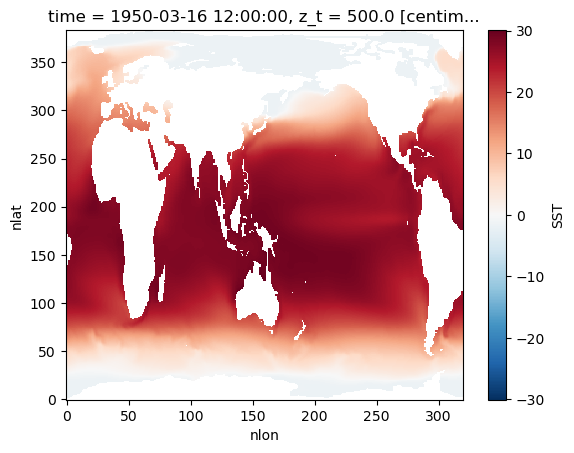

In [9]:
#this is mapping the whole world
ds_20C_mean=ds_20C.mean(dim="member_id")

test_2 = ds_20C_mean.SST.sel(time=slice("1950", "2000"))

test_1950_2 = test_2.sel(time='1950-03')
test_2000_2 = test_2.sel(time='2000-03')

test_1950_2.squeeze().plot()

In [10]:
ds_20C_ch = ds_20C.isel(nlat=slice(240,330), nlon=slice(220,260))
ds_20C_ch

<xarray.Dataset>
Dimensions:     (member_id: 40, time: 1032, z_t: 1, nlat: 90, nlon: 40, d2: 2)
Coordinates:
  * member_id   (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
  * time        (time) object 1920-01-16 12:00:00 ... 2005-12-16 12:00:00
    time_bound  (time, d2) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
  * z_t         (z_t) float32 500.0
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    SST         (member_id, time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 300, 1, 90, 40), meta=np.ndarray>
Attributes: (12/25)
    Conventions:                       CF-1.0; http://www.cgd.ucar.edu/cms/ea...
    NCO:                               4.4.4
    calendar:                          All years have exactly  365 days.
    cell_methods:                      cell_methods = time: mean ==> the vari...
    contents:                          Diagnostic and Prognostic Variables
    nco_openmp_thread_number:          1
    ...                                ...
    intake_esm_attrs:units:            degC
    intake_esm_attrs:start_time:       1920-01-16 12:00:00
    intake_esm_attrs:end_time:         2005-12-16 12:00:00
    intake_esm_attrs:path:             s3://ncar-cesm-lens/ocn/monthly/cesmLE...
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            ocn.20C.monthly

### Data Wrangling

In [11]:
# turn member_id dimension into one value to work with
ds_20C_world = ds_20C.mean(dim = "member_id")
ds_20C_world

<xarray.Dataset>
Dimensions:     (time: 1032, z_t: 1, nlat: 384, nlon: 320, d2: 2)
Coordinates:
  * time        (time) object 1920-01-16 12:00:00 ... 2005-12-16 12:00:00
    time_bound  (time, d2) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
  * z_t         (z_t) float32 500.0
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    SST         (time, z_t, nlat, nlon) float32 dask.array<chunksize=(300, 1, 384, 320), meta=np.ndarray>

### STEP 7 do this step

In [12]:
#for 1920 to 2000
ds_20C_ch_mean=ds_20C_ch.mean(dim="member_id")
ds_20C_world = ds_20C.mean(dim = "member_id")

In [13]:
#see what is in this x array
ds_20C_ch_mean

<xarray.Dataset>
Dimensions:     (time: 1032, z_t: 1, nlat: 90, nlon: 40, d2: 2)
Coordinates:
  * time        (time) object 1920-01-16 12:00:00 ... 2005-12-16 12:00:00
    time_bound  (time, d2) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
  * z_t         (z_t) float32 500.0
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    SST         (time, z_t, nlat, nlon) float32 dask.array<chunksize=(300, 1, 90, 40), meta=np.ndarray>

### STEP 8 slice for 1950 to 2000

In [14]:
#slice for times between 1950 to 2000
#test = ds_20C_ch_mean.SST.sel(time=slice("1950", "2000"))
#test

test = ds_20C_ch_mean.SST.sel(time=slice("1950", "2000"))
test

<xarray.DataArray 'SST' (time: 612, z_t: 1, nlat: 90, nlon: 40)>
dask.array<getitem, shape=(612, 1, 90, 40), dtype=float32, chunksize=(300, 1, 90, 40), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1950-01-16 12:00:00 ... 2000-12-16 12:00:00
  * z_t      (z_t) float32 500.0
Dimensions without coordinates: nlat, nlon

### STEP 9 slice for just 1950

In [15]:
#slice for just 1950-03
test_1950 = test.sel(time='1950-03')
test_2000 = test.sel(time='2000-03')
test_1950


<xarray.DataArray 'SST' (time: 1, z_t: 1, nlat: 90, nlon: 40)>
dask.array<getitem, shape=(1, 1, 90, 40), dtype=float32, chunksize=(1, 1, 90, 40), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1950-03-16 12:00:00
  * z_t      (z_t) float32 500.0
Dimensions without coordinates: nlat, nlon

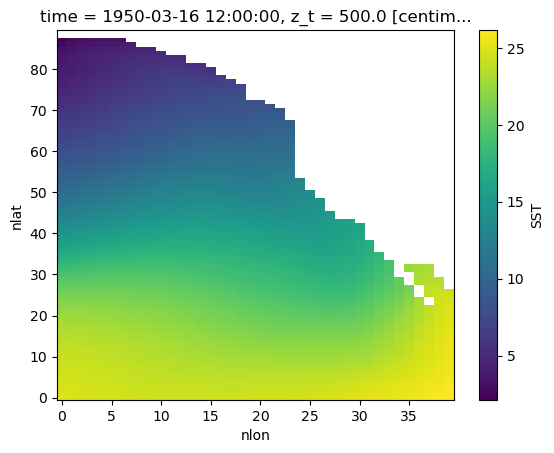

In [16]:
test_1950.squeeze().plot()

In [17]:
#slice for just 1950-03
test_1950_ch = ds_20C_ch.sel(time='1950-03')
test_2000_ch = ds_20C_ch.sel(time='2000-03')
test_1950_ch

<xarray.Dataset>
Dimensions:     (member_id: 40, time: 1, z_t: 1, nlat: 90, nlon: 40, d2: 2)
Coordinates:
  * member_id   (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
  * time        (time) object 1950-03-16 12:00:00
    time_bound  (time, d2) object dask.array<chunksize=(1, 2), meta=np.ndarray>
  * z_t         (z_t) float32 500.0
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    SST         (member_id, time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 1, 1, 90, 40), meta=np.ndarray>
Attributes: (12/25)
    Conventions:                       CF-1.0; http://www.cgd.ucar.edu/cms/ea...
    NCO:                               4.4.4
    calendar:                          All years have exactly  365 days.
    cell_methods:                      cell_methods = time: mean ==> the vari...
    contents:                          Diagnostic and Prognostic Variables
    nco_openmp_thread_number:          1
    ...                                ...
    intake_esm_attrs:units:            degC
    intake_esm_attrs:start_time:       1920-01-16 12:00:00
    intake_esm_attrs:end_time:         2005-12-16 12:00:00
    intake_esm_attrs:path:             s3://ncar-cesm-lens/ocn/monthly/cesmLE...
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            ocn.20C.monthly

In [18]:
#turn them into dataframes to see the valuse
test_1950_df = test_1950.to_dataframe()
test_2000_df = test_2000.to_dataframe()
test_2000_df.head()

SST
time                z_t   nlat nlon           
2000-03-16 12:00:00 500.0 0    0     24.987906
                               1     24.954258
                               2     24.905754
                               3     24.842829
                               4     24.780087

In [19]:
#drop na as well as look at the values
test_4 = test_1950_df.dropna()
print(test_4.SST.max())
print(test_4.SST.min())

26.148392
2.1455727


In [20]:
print(test_2000_df.dropna().SST.max())
print(test_2000_df.dropna().SST.min())

26.335852
2.0430634


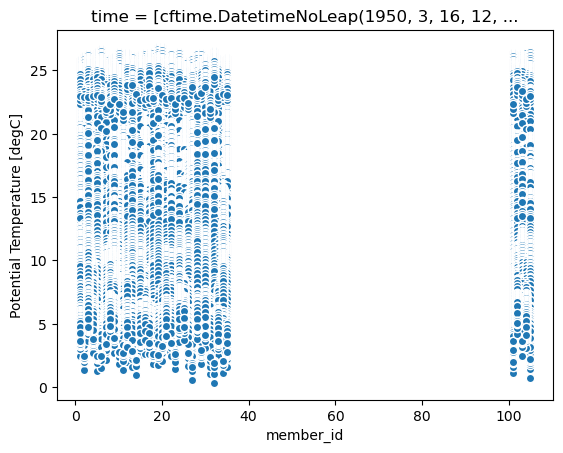

In [21]:
test_1950_ch.SST.plot.scatter()

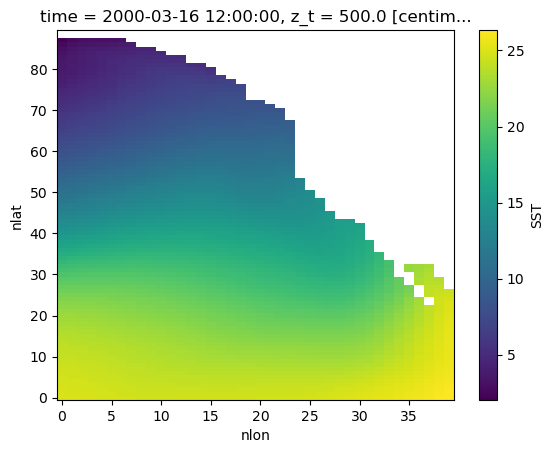

In [22]:
test_2000.squeeze().plot()

In [23]:
# define the extent of the map
projPC = ccrs.PlateCarree()
lonW = -140
lonE = -40
latS = 15
latN = 65
cLat = (latN + latS) / 2
cLon = (lonW + lonE) / 2
res = '110m'

AttributeError: 'GeoAxes' object has no attribute 'test_2000'

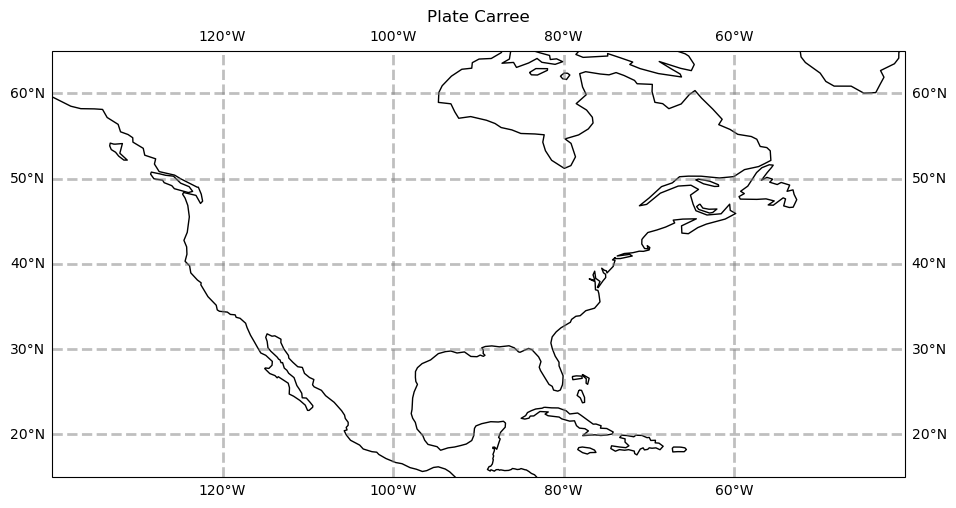

In [24]:
# what does sea surface temperature around the US look like? (i.e. where would you like to go swimming..)
# Create a plot
fig = plt.figure(figsize=(11, 8.5))
ax = plt.subplot(1, 1, 1, projection=projPC)
ax.set_title('Plate Carree')
gl = ax.gridlines(
    draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--'
)
ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
ax.coastlines(resolution=res, color='black')
dataplot = ax.test_2000(nlon, nlat, transform=ccrs.PlateCarree())



#fig, ax = plt.subplots(figsize=(30, 20), 
#                       subplot_kw={'projection': ccrs.PlateCarree()})
#ax.set_title('')
#ax.set_extent([lonW, lonE, latS, latN], crs = ccrs.PlateCarree())
#tdat = ax.pcolormesh(test_2000.isel(z_t=0, time=1), cmap='RdYlBu_r')
#plt.colorbar(tdat, ax=ax, shrink=0.5, pad=0.1)
#plt.savefig('basics_plot_4.png', bbox_inches='tight')# uncomment this to save your figure

# subsetting to just channel islands

In [ ]:
#import geopandas as gpd

# path to channel island shapefile
#cinms = 'cinms_py'

# Read the shapefile
#pts = gpd.read_file(cinms)

# Read the shapefile
#cinms_shape = gpd.read_file(cinms).to_crs(4326)

#cinms_shape.plot()

# Define the target projected CRS (e.g., WGS 84 / Pseudo-Mercator)
#target_crs = 'EPSG:3857'  # WGS 84 / Pseudo-Mercator EPSG code

# Reproject the geometries to the target CRS
#pts = pts.to_crs(target_crs)

#pts.plot()

### ignore:

In [ ]:

#view contents of channel island geopanda dataframe
#pts

In [ ]:
#find coordinates of channel islands
ch_coords = pts.get_coordinates()
ch_coords

In [ ]:
# Add multiple columns using dictionary assignment
#adding back into pts dataframe
# creating new columns for lat and long
#new_data = {'x': ch_coords["x"], 'y': ch_coords["y"] }
#pts = pts.assign(**new_data)

#just add one into pts dataframe
#pts['x'] = ch_coords["x"]
#pts

In [ ]:
import numpy as np
# Get the centroid of each geometry
#centroids = pts.geometry.centroid
#centroids
#here i want to extract shape file points and match them to the xarray dataset file I have in CMIP6
#lons = np.array(centroids.geometry.x.to_list())
#lats = np.array(centroids.geometry.y.to_list())
#lons

### STEP 10 subset to just channel islands

<Axes: >

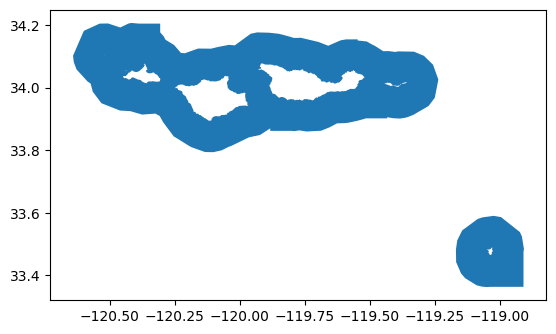

In [1]:
import geopandas as gpd

# path to channel island shapefile
cinms = '../cinms_py'

# Read the shapefile
pts = gpd.read_file(cinms)

# Read the shapefile
cinms_shape = gpd.read_file(cinms).to_crs(4326)

cinms_shape.plot()

In [ ]:
pts.head()

In [ ]:
cinm_0 = cinms_shape.total_bounds[0]
cinm_2 = cinms_shape.total_bounds[2] 
cinm_1 = cinms_shape.total_bounds[1]
cinm_3 = cinms_shape.total_bounds[3]

## Diana's stuff This is where I was able to get the map to render above are the steps that I took to get to this point

### STEP 11 get graph

In [ ]:
import cartopy.crs as ccrs

# Create a plot
fig, ax = plt.subplots(figsize=(20, 10), 
                       subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the Xarray dataset as background
test_1950.plot(ax=ax, 
         transform=ccrs.PlateCarree())

# Set the extent of the plot based on the shapefile bounding box
ax.set_extent([cinm_0, cinm_2, cinm_1, cinm_3])

# Plot the shapefile
cinms_shape.plot(ax=ax, 
                 facecolor = "none")

scale_bar_kwargs = {'location': (0.5, 0.05),
                    'length_fraction': 0.1}

# Add gridlines
ax.gridlines(draw_labels=True)

# Add a title
ax.set_title('Channel Islands Marine Sanctuary Sea Surface Temperature',
            size = 40)

ax.set_xticklabels (x_ticks, rotation=0, fontsize=8)
ax.set_yticklabels (y_ticks, rotation=0, fontsize=8)

#ax.yaxis.set_major_formatter(size = 15) 
#ax.xaxis.set_major_formatter(size = 15) 

ax.legend()

# Show the plot
plt.show()

plt.savefig('chsst.png')

#questions: is the xarray data not showing up properly?
#question: can we change the scale on the right? (ex. make it zoom into just a certain range)

In [ ]:
# Create a plot
fig, ax = plt.subplots(figsize=(30, 20), 
                       subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the Xarray dataset as background
test_2000.plot(ax=ax, 
         transform=ccrs.PlateCarree())

# Set the extent of the plot based on the shapefile bounding box
ax.set_extent([cinm_0, cinm_2, cinm_1, cinm_3])

# Plot the shapefile
cinms_shape.plot(ax=ax, facecolor = "none")

# Add gridlines
ax.gridlines(draw_labels=True)

# Add a title
ax.set_title('Channel Islands Marine Sanctuary Sea Surface Temperature')

# Show the plot
plt.show()
